# Iris Classification with NLP

In this tutorial, we will explore how to use natural language processing (NLP) to classify iris flowers based on their sepal and petal measurements using TrueFoundry.

The dataset contains descriptions of the `sepal length`, `sepal width`, `petal length`, and `petal width` for each flower, along with the species label (`setosa`, `versicolor`, or `virginica`).


# 🛠 Setup

To follow along with the notebook, you will have to do the following:

- Install **truefoundry** and required ML Libraries
- Setup logging
- Select the Workspace in which you want to deploy your application.
- Install the required packages


In [ ]:
!pip install -U -q "scikit-learn==1.2.2" "joblib==1.3.2"  "pandas==2.1.0" "truefoundry[ml]==0.1.0"

In [ ]:
import logging

[logging.root.removeHandler(h) for h in logging.root.handlers]
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s [%(name)s] %(levelname)-8s %(message)s"
)

### Login into truefoundry

In order to login run the cell below. Host can be found from the Truefoundry UI as shown below like https://app.truefoundry.com

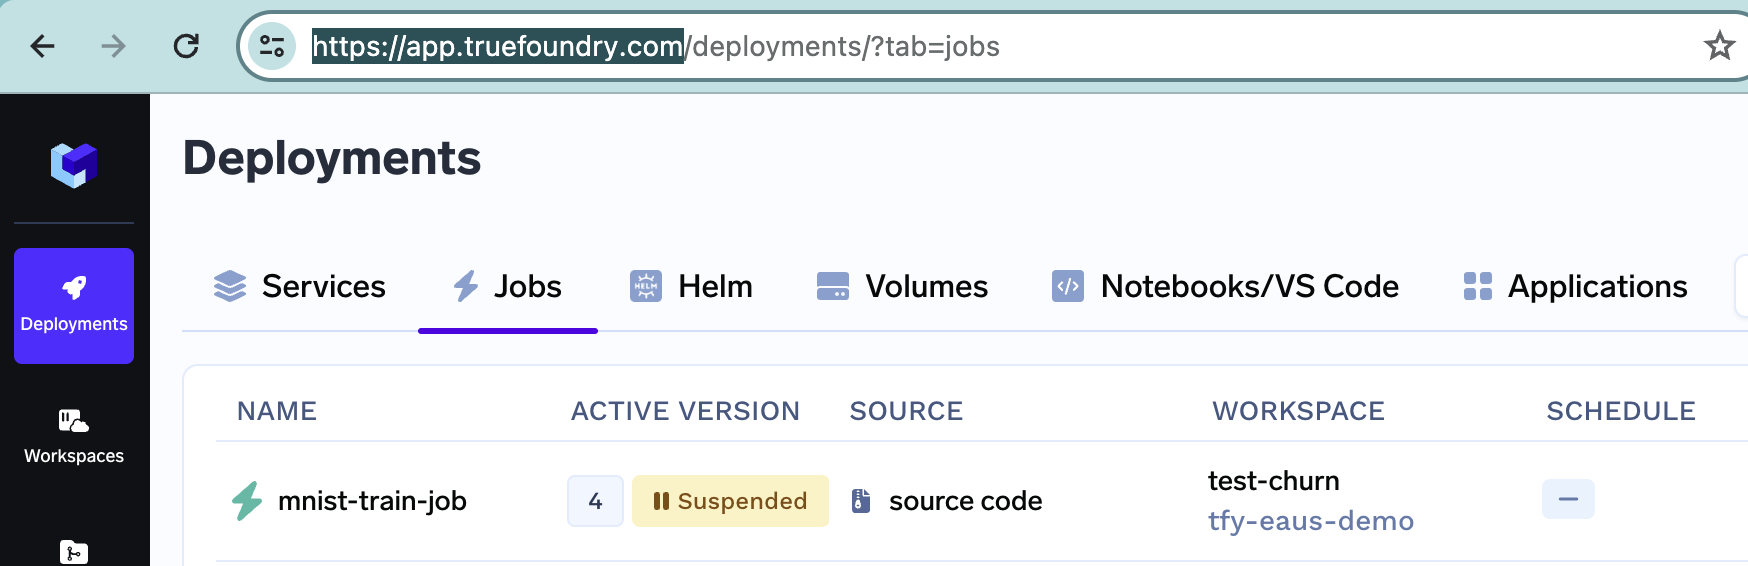


In [ ]:
!truefoundry login --host <Host name of Truefoundry UI. e.g. https://company.truefoundry.cloud>

### Workspace FQN

Once you run the cell below you will get a prompt to enter your workspace. <br>

- Step 1: Click on the link given in the prompt.
- Step 2: Identify the Workspace you want to deploy the application in.
- Step 3: Copy the Workspace FQN <br>
  ![Copying Workspace FQN](https://files.readme.io/730fee2-Screenshot_2023-02-28_at_2.08.34_PM.png)
- Step 4: Paste the Workspace FQN in the prompt and press enter.


In [ ]:
WORKSPACE_FQN = input("Enter the FQN of the workspace to use: ")

# Dataset Description

The dataset contains 150 samples of iris flowers, with each sample containing the following features:

- Sepal length
- Sepal width
- Petal length
- Petal width
- Species label (setosa, versicolor, virginica)


In [ ]:
from sklearn import datasets

iris = datasets.load_iris()

# Extracting features
features = iris.data

# Extracting Target / Class Labels
target = iris.target

# Model Building

We will use scikit-learn, a popular machine learning library, to build the model. It's important to save the trained model as an artifact for later use. Model artifacts are essential because they contain the learned parameters and configurations of the model, enabling us to deploy and use the model in different environments without retraining.

We will be using `mlfoundry` for logging and storing artifacts.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score
import mlfoundry

from truefoundry.ml import ModelFramework
import joblib

X_train, X_test, y_train, y_test = train_test_split(
    features, target, random_state=50, test_size=0.25
)

client = mlfoundry.get_client()
ml_repo = "iris-demo"
client.create_ml_repo(ml_repo=ml_repo)


run = client.create_run(ml_repo=ml_repo, run_name="dtc-model")
with run:
    params = {"max_depth": 5}

    classifier = DecisionTreeClassifier(**params)
    run.log_params(params)

    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")

    run.log_metrics(metric_dict={"accuracy": accuracy, "f1_score": f1})

    joblib.dump(classifier, "iris_classifier.joblib")
    model_version = run.log_model(
        name="iris-classification-model",
        model_file_or_folder="iris_classifier.joblib",
        framework=ModelFramework.SKLEARN,
        metadata={"accuracy": accuracy, "f1": f1},
    )

# Using LLM from Truefoundry LLM gateway

Experimenting with open-source LLMs can be challenging as it requires setting up GPUs and loading models, incurring time and cost. Truefoundry offers an experimental playground where you can try various open-source models as APIs without deploying them yourself. Once you find the best model, you can host it on your cloud or ask Truefoundry to set up a production-ready environment. The playground also supports integration with OpenAI and other providers for response comparison. This simplifies the testing process compared to OpenAI, which provides ready-to-use LLMs as an API.

You can compare the responses from different llm's from Truefoundry using [LLM playground](https://docs.truefoundry.com/docs/llm-gateway).


# Developing LLM Function.

Developing the LLM function involves crafting a prompt to gather information in JSON format, which is then passed to the classification model.

This JSON format is structured data that can be easily understood by the classification model, allowing for seamless communication between the LLM and the model.


In [ ]:
!pygmentize llm.py

import os

import requests

SYSTEM_PROMPT = """
Given a natural language description of a flower's sepal and petal measurements as input, return a JSON object with the measurements. If a measurement is not mentioned, set its value to 0. The input sentence will contain descriptions of the sepal length, sepal width, petal length, and petal width.

For example:

Example 1:
Input: "The flower has a sepal length of 5.1cm, a sepal width of 3.5cm, a petal length of 1.4cm and a petal width of 0.2cm."

{"sepal_length": 5.1, "sepal_width": 3.5, "petal_length": 1.4, "petal_width": 0.2}


Example 2:
Input: "The sepal length measures 4.9cm and the sepal width is 3.0cm."

{"sepal_length": 4.9, "sepal_width": 3.0, "petal_length": 0, "petal_width": 0}

Input: 
"""

TFY_LLM_GATEWAY_HOST = os.environ[
    "TFY_LLM_GATEWAY_HOST"
]  # Ex: https://*.truefoundry.tech/v1/chat/completions

TFY_API_KEY = os.environ["TFY_API_KEY"]
LLM_MODEL = os.environ["LLM_MODEL"]


def llm(prompt):
    response = requests.po

## Deploying the service


### Inference Scripts

#### Combining LLM and Classification

By combining the NLP module with the trained classification model, we create a seamless user experience. Users can input natural language queries about iris flowers, and the model will extract the relevant information and make predictions based on that.


In [ ]:
!pygmentize app.py

import json
import os

import joblib
import pandas as pd
from fastapi import FastAPI
from llm import llm

artifact_downloaded_path = os.environ["CLASSIFIER_MODEL_PATH"]
classifier = joblib.load(
    os.path.join(artifact_downloaded_path, "iris_classifier.joblib")
)

app = FastAPI(docs_url="/", root_path=os.getenv("TFY_SERVICE_ROOT_PATH", "/"))

IRIS_CLASSES = {0: "Setosa", 1: "Versicolour", 2: "Virginica"}


@app.post("/prompt")
def predict(prompt: str):
    response = llm(prompt=prompt)
    data = json.loads(response)
    prediction = int(classifier.predict(pd.DataFrame([data]))[0])
    return {"flower_name": IRIS_CLASSES[prediction], "features": data}


### Deploy on Truefoundry as Service


In [ ]:
!pygmentize deploy.py

import argparse
import logging

from truefoundry.deploy import (
    ArtifactsDownload,
    Build,
    Port,
    PythonBuild,
    Resources,
    Service,
    TruefoundryArtifactSource,
)

logging.basicConfig(level=logging.INFO)

parser = argparse.ArgumentParser()
parser.add_argument("--name", required=True, type=str, help="Name of the application.")
parser.add_argument(
    "--workspace_fqn",
    required=True,
    type=str,
    help="FQN of the workspace where application will be deployed.",
)
parser.add_argument(
    "--host",
    required=True,
    type=str,
    help="Host where the application will be available for access. Ex:- my-app.my-org.com",
)
parser.add_argument(
    "--llm_gateway_host",
    required=True,
    type=str,
    help="Host where the llm will be available for access.",
)
parser.add_argument("--path", type=str, required=False)
parser.add_argument(
    "--model_version_fqn",
    type=str,
    required=True,
    help="FQN of the model in mlrepo ",
)
parser.add_argum

In [ ]:
SERVICE_NAME = input("Enter the Service name")
SERVICE_HOST = input(
    "Enter the Service Host (Can be found from cluster details in Truefoundry UI)"
)
SERVICE_PATH = input(
    "Enter the Service Path where you want your service to be deployed"
)
CLASSIFICATION_MODEL_FQN = input("Enter FQN of the model artifact")
LLM_GATEWAY_HOST = input(
    "Enter llm gateway host for chat model. E.g.: https://truefoundry.<company_name>.com/api/llm/openai/chat/completions"
)
LLM_MODEL = input("Enter LLM Model name (Ex: openai/gpt-4")

In [ ]:
!python deploy.py --name $SERVICE_NAME --workspace_fqn $WORKSPACE_FQN --host $SERVICE_HOST --path $SERVICE_PATH --model_version_fqn $CLASSIFICATION_MODEL_FQN --llm_gateway_host $LLM_GATEWAY_HOST --llm_model $LLM_MODEL